## Pre-request setup

### Tensorflow

Current working version for tensorflow is v2.3.
Install the tensorflow and other [requirements](https://www.tensorflow.org/install/gpu) for getting GPU support.

To use the CUDA, make sure the GPU you used is in the [CUDA capatable list](https://developer.nvidia.com/cuda-gpus)

#### CUDA Toolkit
Check the pre-requirment based on the [CUDA toolkit installation guide](https://docs.nvidia.com/cuda/cuda-installation-guide-linux/index.html#verify-you-have-cuda-enabled-system).

Download the [CUDA Toolkit 10.1 and CUPTI](https://developer.nvidia.com/cuda-10.1-download-archive-base), installing commands:
```sh
sudo dpkg -i cuda-repo-ubuntu1810-10-1-local-10.1.105-418.39_1.0-1_amd64.deb
sudo apt-key add /var/cuda-repo-<version>/7fa2af80.pub
sudo apt-get update
sudo apt-get install cuda
```
#### cuDNN
Download the `version 7.6.5` of cuDNN from the [archive of the cuDNN](https://developer.nvidia.com/rdp/cudnn-archive) , unzip it and then install it by:
```sh
sudo cp cuda/include/cudnn*.h /usr/local/cuda/include
sudo cp cuda/lib64/libcudnn* /usr/local/cuda/lib64
sudo chmod a+r /usr/local/cuda/include/cudnn*.h /usr/local/cuda/lib64/libcudnn*

Add the environment variable:
```sh
export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:/usr/local/cuda/extras/CUPTI/lib64
```

Don't forget to reboot the machine to let the system detect the GPU.

# dOD

### Sample preparation

For the sample preparation, a `dataWrapper` base object is made targeting to standardize
the sample API. Three major functions:
1. `pop` (vritual) : generate a single sample
2. `generate`: generate a batch of samples.
3. `show` : generate few samples with visualization

For new sample generator, inherit the `dataWrapper`module in `sample` folder and implement the `pop` for different sample object.


<IPython.core.display.Javascript object>


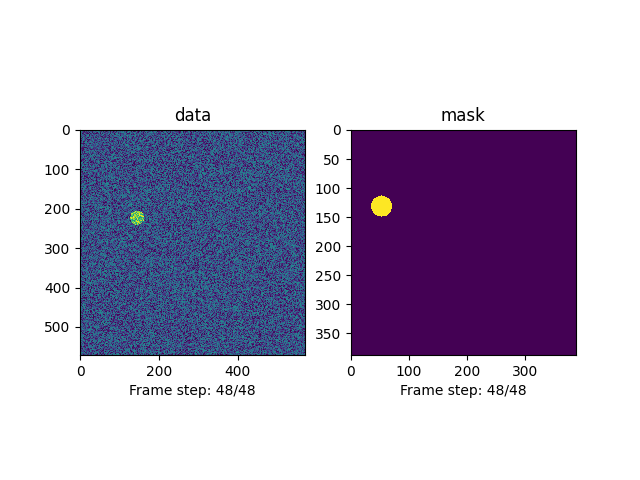

In [3]:
%matplotlib notebook
import sys
sys.path.insert(1, '/home/tabris/flShrine/dOD/sample')

import sample_v0 as sp

sg = sp.sample_v0('geo0', 572, 572, [92,92], 12, radius = 18, dtype='float32')
sg.show()

## Model structure

A good website for ML: [Dive into deep learning](http://d2l.ai/index.html#)

### Convolutional layer
Refering to this [introduction](https://cs231n.github.io/convolutional-networks/).
Given an input tensor $x$ with the shape $W_0\times H_0\times D_0$, a 2D convolutional layer with a $W\times H\times D$ kernel $K$ has $(W\times H\times D_0+1)\times D$ the independent variables (including biases) based on the sharing parameter strategy. They are $D$ filters and each of them has $D_0$ layers ($L^j_i$, the i-th layer of the j-th filter) with shape $W\times H$. One bias is assigned to each filter. 

Denote the convolution operation between $A$ and $B$ by $A\circ B$, then the j-th depth convolution layer output can be expressed as

$$
O^j=b_j+\sum_{i=1}^{D_0}L^j_i\circ x_i
$$


### Softdrop

The function of this layer is to prevent the over-fitting. It will randomly disable some of the elements from the input, and the probablity for disabling the elements are called drop-rate.

### Max pool layer

The function of the max pool layer is preventing the over-fitting by reducing the outputs from selecting the maximum value among the inputs within a loca region as the outputs. For instance, for a size $W\times H$ max pooling layer, it will slice the input into a many small region with shape $W\times H$, (padding or stride may apply). And only the maximum value of each slices will be the output from that region.

### Transpose convolutional layer
More conceptial detials could be found [here](http://d2l.ai/chapter_computer-vision/transposed-conv.html)



## Loss function and accuracy

### cross-entropy

#### standard
Suppose the prediction output is a tensor $p_{i}$ and the truth is $x_{i}$, then the cross entroy py is defined as

$$
H(x,p) = \frac{1}{N}\sum_{i=1}^N-x_i\log p_i,
$$

where the truth $x_i$ can be either 0 or 1 and $p_i<1$. The summary of the feagures:

* Only the preidiction on the truth bit will affect the loss, no penlty/reward for the prediction on other bits.
* Exponentially sensetive for the predictoin on the truth bit.

#### Binary cross-entropy
Suppose the prediction $p_i$ is a binary variable (either 0 or 1), the cross-entropy could be modified to be

$$
H'(x,p)= \frac{1}{N}\sum_{i=1}^N-x_i\log p_i-(1-x_i)\log (1-p_i),
$$

which makes the wrong prediction takes penalty as well.

#### categorical cross-entropy

## U-net attemptation



In [1]:
import sys
sys.path.insert(1, '/home/tabris/flShrine/dOD/tf_model')
sys.path.insert(1, '/home/tabris/flShrine/dOD/sample')

import sample_v0 as sp
import numpy as np
%load_ext tensorboard
import tensorflow as tf
from model import *


m = mynet(input_shape=(572,572,12),padding = 'valid', dtype='float16', drop_rate=0.2)
m.buildNet(False)


In [2]:

sg = sp.sample_v0('geo0', 572, 572, [92,92], 12, radius = 18)
m.net.summary()

nbatch = 20
batch_size = 2
samples = []
masks =[]
for i in range(nbatch):
    samples, masks = sg.generate(batch_size)
    #print(samples.shape)
    #print(masks.shape)
    samples = samples.astype(np.float16)
    masks = masks.astype(np.float16)
    m.net.fit(x=samples, y = masks, epochs = 1, batch_size = batch_size)

#%tensorboard --logdir logs


Model: "test"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, 572, 572, 12 0                                            
__________________________________________________________________________________________________
sequential_conv2d_layer (sequen (None, 568, 568, 64) 43904       inputs[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 284, 284, 64) 0           sequential_conv2d_layer[0][0]    
__________________________________________________________________________________________________
sequential_conv2d_layer_1 (sequ (None, 280, 280, 128 221440      max_pooling2d[0][0]              
_______________________________________________________________________________________________

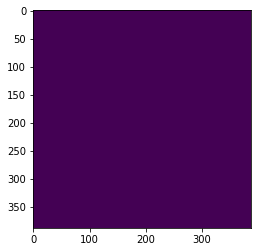

In [3]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

x, t = sg.generate(1)
y = m.predict(x)

#print(y[0,:,:,0].dtype)
image = y[0,:,:,0].astype(np.float32)
ax.imshow(image)

<IPython.core.display.Javascript object>


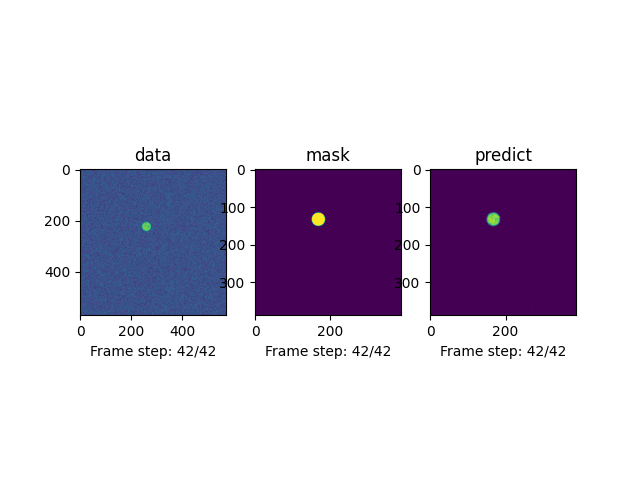

42


In [9]:
import sys
sys.path.insert(1, '/home/tabris/flShrine/dOD/tf_model')
sys.path.insert(1, '/home/tabris/flShrine/dOD/sample')

import sample_v0 as sp
import numpy as np
import tensorflow as tf
from model import *


m = mynet(input_shape=(572,572,6),padding = 'valid', dtype='float32', drop_rate=0.2)
m.buildNet()
m.net.load_weights('../data/unet_v0_ckpt.h5')
%matplotlib notebook
sg = sp.sample_v0('geo0', 572, 572, [92,92], 6, radius = 18)
sg.check(m)

(1, 388, 388, 1)
(1, 572, 572, 6)
(1, 388, 388, 1)


<IPython.core.display.Javascript object>


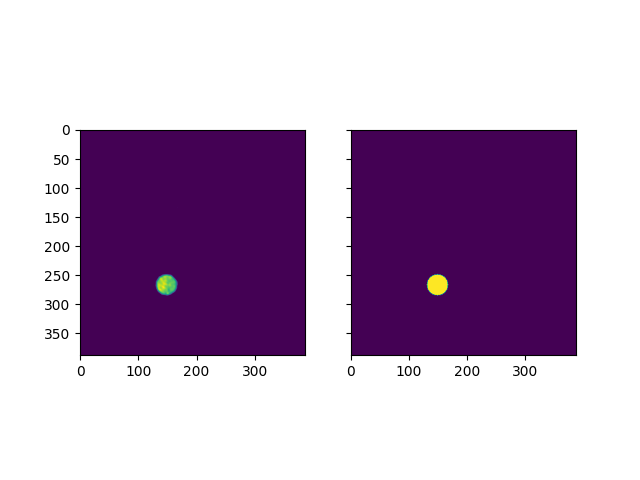

In [6]:

import matplotlib.pyplot as plt

sg = sp.sample_v0('geo0', 572, 572, [92,92], 6, radius = 18)
x, t = sg.generate(1)
y = m.predict(x)
print(t.shape)
print(x.shape)
print(y.shape)
image = y[0,:,:,0].astype(np.float32)
#image = y[0,:,:,0]
fig,(ax1,ax2) = plt.subplots(1,2, sharey=True)
ax1.imshow(image)
ax2.imshow(t[0,:,:,0])

<IPython.core.display.Javascript object>


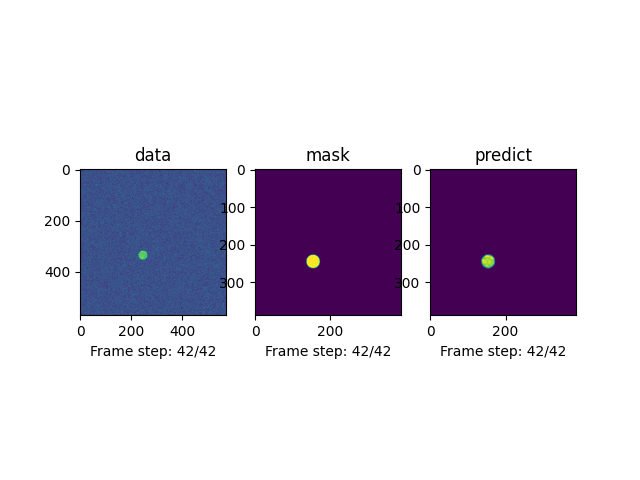

42
